In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import train
import pickle


In [2]:
dfList = train.transform("data.json")
#df.shape

In [3]:
df1List = dfList
dfList = df1List
for df in dfList:
    scaler = MinMaxScaler(feature_range=(0,1)).fit(df)
    df = scaler.transform(df)
#print(dfList[12])
#print(dfList[0].head(5))

In [2]:
def eval(accList, precisionList, tprList, farList, frrList, y, y_pred):
    avgaccuracy = 0
    avgPrecision = 0
    avgTpr = 0
    avgFar = 0
    avgFrr = 0
    for i in range(len(accList)):
        avgaccuracy += accList[i]
        avgPrecision += precisionList[i]
        avgTpr += tprList[i]
        avgFar += farList[i]
        avgFrr += frrList[i]
    avgaccuracy = avgaccuracy / len(accList)
    avgPrecision = avgPrecision / len(precisionList)
    avgTpr = avgTpr / len(tprList)
    avgFar = avgFar / len(farList)
    avgFrr = avgFrr / len(frrList)
    
    fprROC, tprROC, threshold = roc_curve(y, y_pred, pos_label=1) #fprROC == avgFar, tprROC == avgTpr
    fnrROC = 1 - tprROC #fnrROC == avgFrr
    EER = fprROC[np.nanargmin(np.absolute((fnrROC - fprROC)))]

    print("average acc = "+str(avgaccuracy))
    print("average precision = "+str(avgPrecision))
    print("average TPR = "+str(avgTpr))
    print("average FAR = "+str(avgFar))
    print("average FRR = "+str(avgFrr))
    print("average EER = "+str(EER))

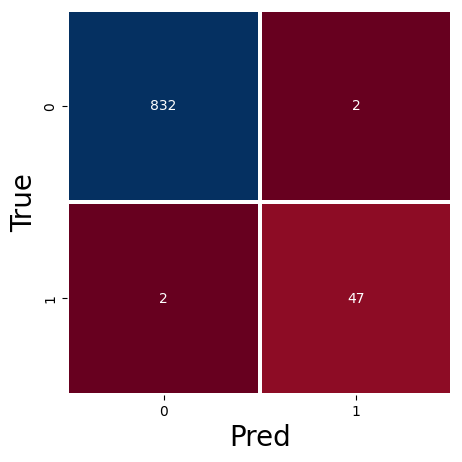

acc = 0.9954699886749717
precision = 0.9591836734693877
TPR = 0.9591836734693877
FAR = 0.002398081534772182
FRR = 0.04081632653061224


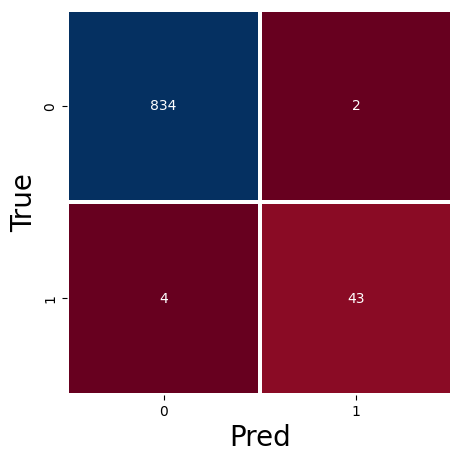

acc = 0.9932049830124575
precision = 0.9555555555555556
TPR = 0.9148936170212766
FAR = 0.0023923444976076554
FRR = 0.0851063829787234


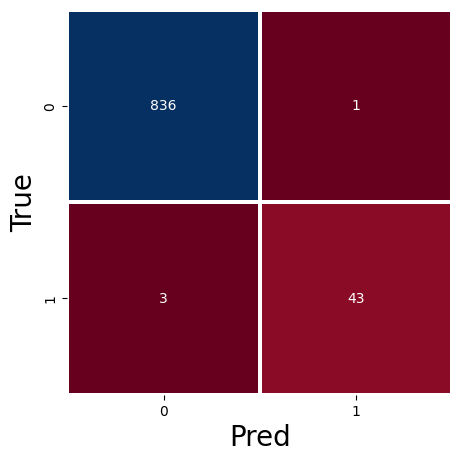

acc = 0.9954699886749717
precision = 0.9772727272727273
TPR = 0.9347826086956522
FAR = 0.0011947431302270011
FRR = 0.06521739130434782


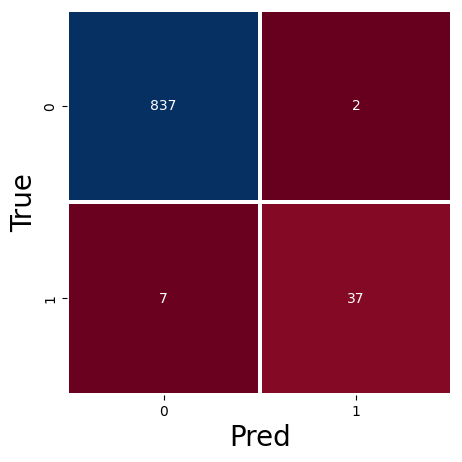

acc = 0.9898074745186863
precision = 0.9487179487179487
TPR = 0.8409090909090909
FAR = 0.0023837902264600714
FRR = 0.1590909090909091


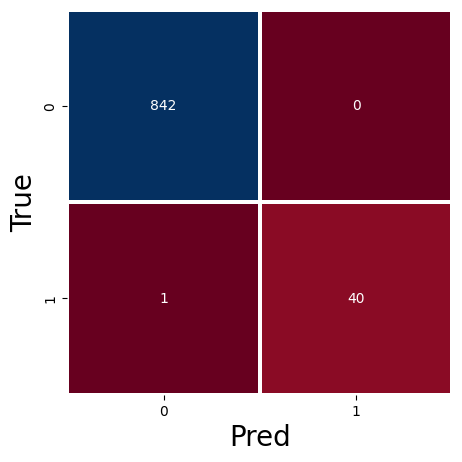

acc = 0.9988674971687429
precision = 1.0
TPR = 0.975609756097561
FAR = 0.0
FRR = 0.024390243902439025


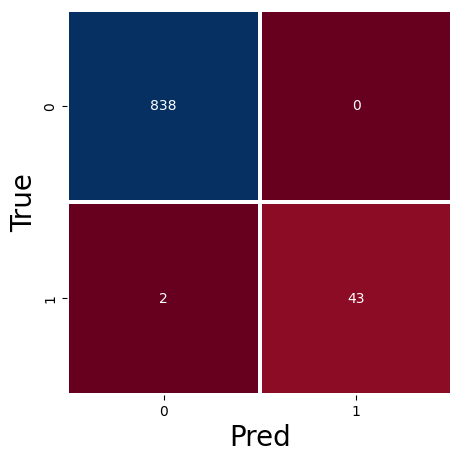

acc = 0.9977349943374858
precision = 1.0
TPR = 0.9555555555555556
FAR = 0.0
FRR = 0.044444444444444446


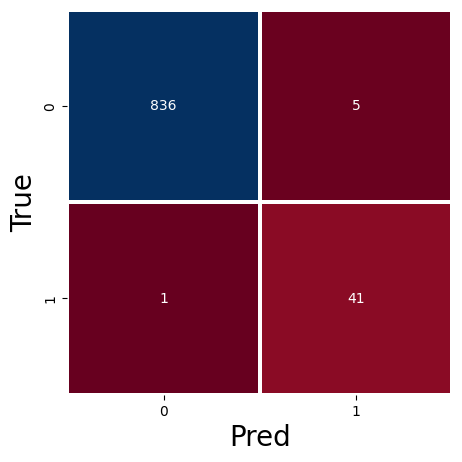

acc = 0.9932049830124575
precision = 0.8913043478260869
TPR = 0.9761904761904762
FAR = 0.005945303210463734
FRR = 0.023809523809523808


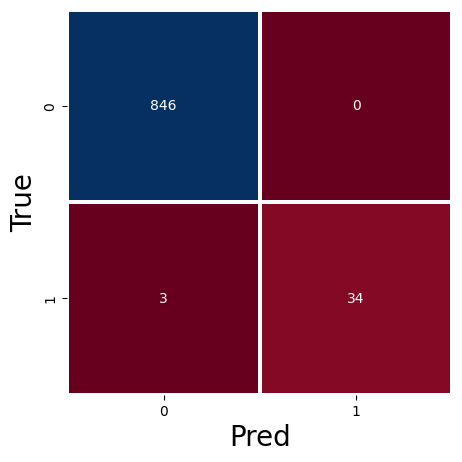

acc = 0.9966024915062288
precision = 1.0
TPR = 0.918918918918919
FAR = 0.0
FRR = 0.08108108108108109


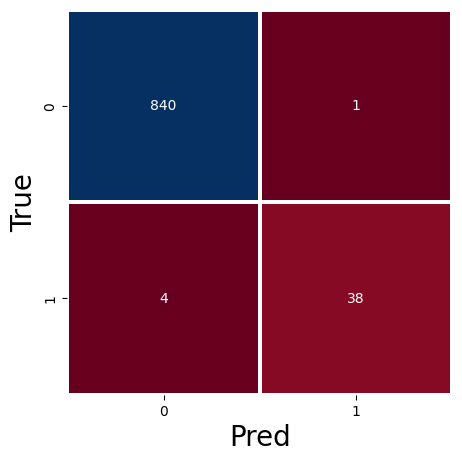

acc = 0.9943374858437146
precision = 0.9743589743589743
TPR = 0.9047619047619048
FAR = 0.0011890606420927466
FRR = 0.09523809523809523


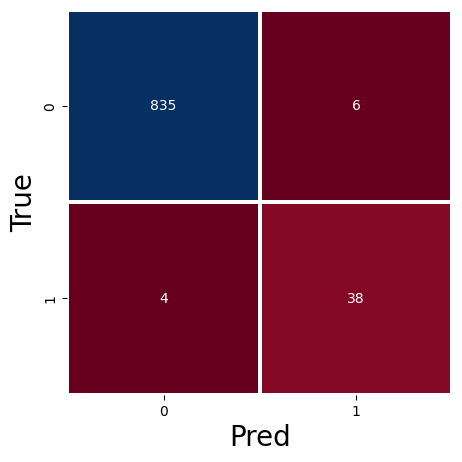

acc = 0.9886749716874292
precision = 0.8636363636363636
TPR = 0.9047619047619048
FAR = 0.007134363852556481
FRR = 0.09523809523809523


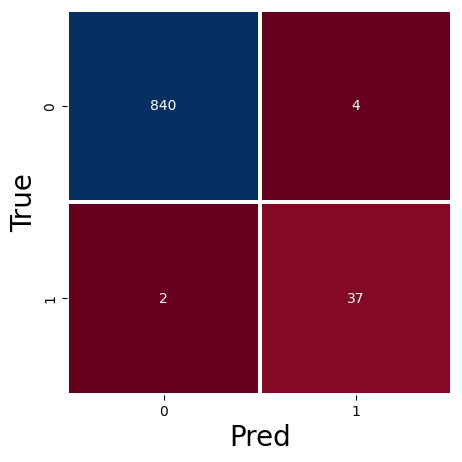

acc = 0.9932049830124575
precision = 0.9024390243902439
TPR = 0.9487179487179487
FAR = 0.004739336492890996
FRR = 0.05128205128205128


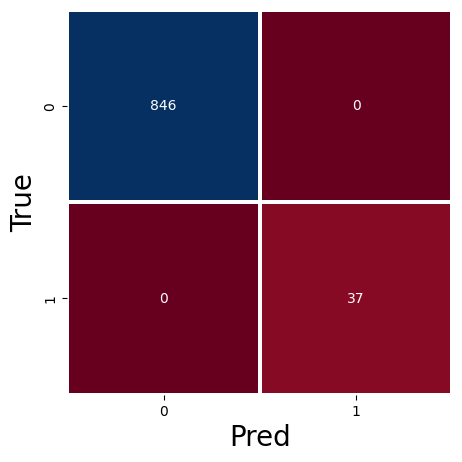

acc = 1.0
precision = 1.0
TPR = 1.0
FAR = 0.0
FRR = 0.0


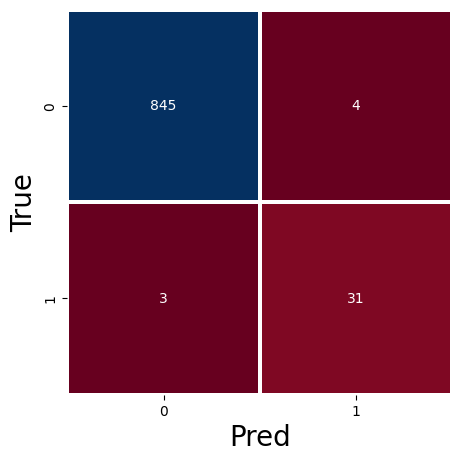

acc = 0.9920724801812004
precision = 0.8857142857142857
TPR = 0.9117647058823529
FAR = 0.004711425206124852
FRR = 0.08823529411764706


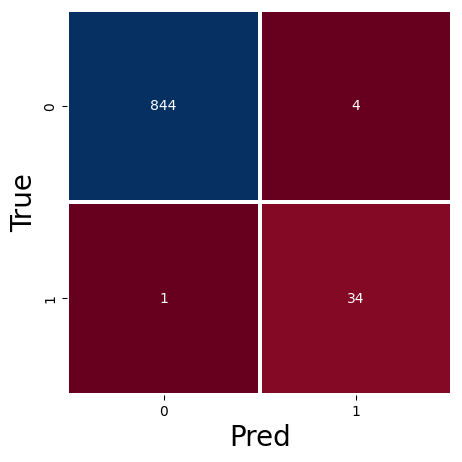

acc = 0.9943374858437146
precision = 0.8947368421052632
TPR = 0.9714285714285714
FAR = 0.0047169811320754715
FRR = 0.02857142857142857


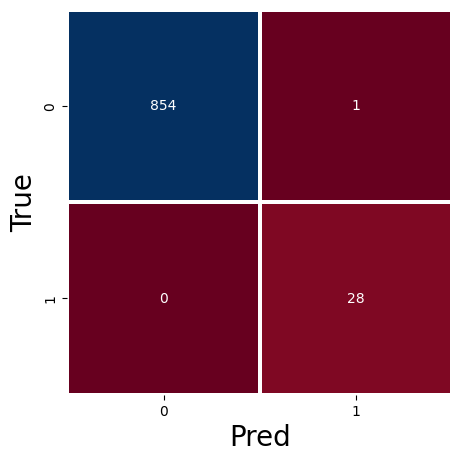

acc = 0.9988674971687429
precision = 0.9655172413793104
TPR = 1.0
FAR = 0.0011695906432748538
FRR = 0.0


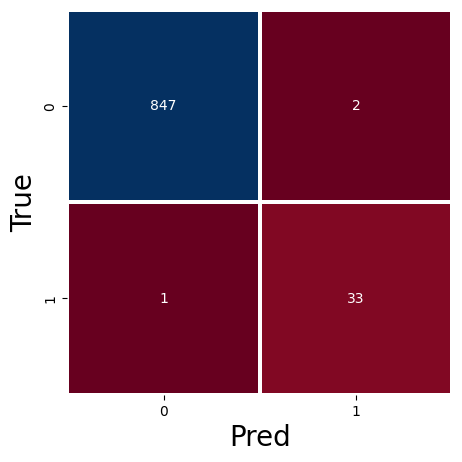

acc = 0.9966024915062288
precision = 0.9428571428571428
TPR = 0.9705882352941176
FAR = 0.002355712603062426
FRR = 0.029411764705882353


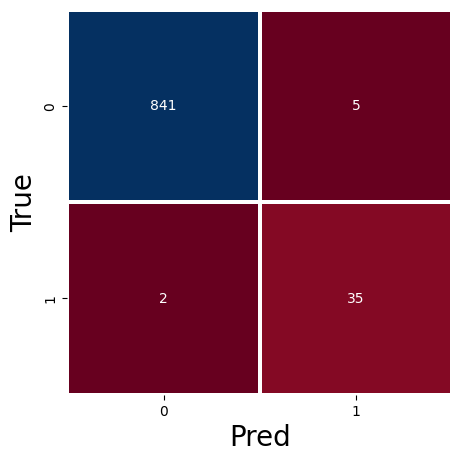

acc = 0.9920724801812004
precision = 0.875
TPR = 0.9459459459459459
FAR = 0.00591016548463357
FRR = 0.05405405405405406


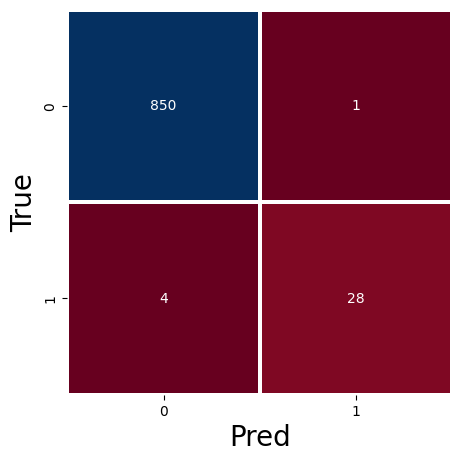

acc = 0.9943374858437146
precision = 0.9655172413793104
TPR = 0.875
FAR = 0.0011750881316098707
FRR = 0.125


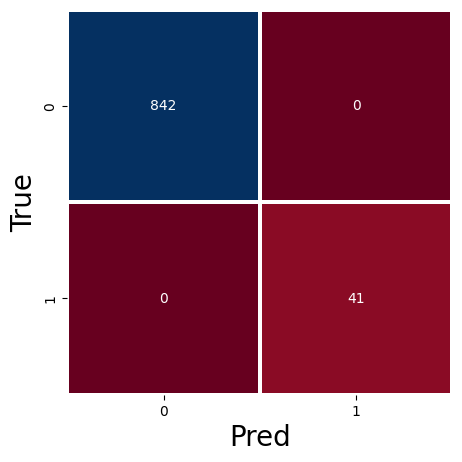

acc = 1.0
precision = 1.0
TPR = 1.0
FAR = 0.0
FRR = 0.0


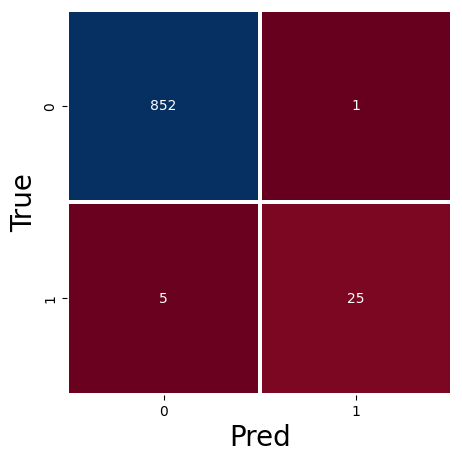

acc = 0.9932049830124575
precision = 0.9615384615384616
TPR = 0.8333333333333334
FAR = 0.0011723329425556857
FRR = 0.16666666666666666


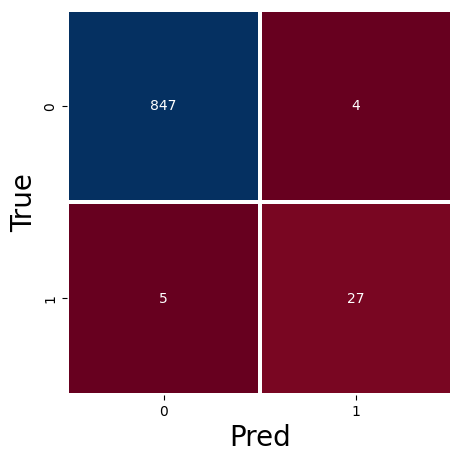

acc = 0.9898074745186863
precision = 0.8709677419354839
TPR = 0.84375
FAR = 0.004700352526439483
FRR = 0.15625


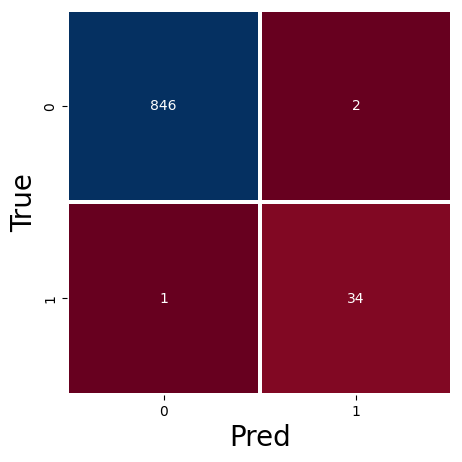

acc = 0.9966024915062288
precision = 0.9444444444444444
TPR = 0.9714285714285714
FAR = 0.0023584905660377358
FRR = 0.02857142857142857


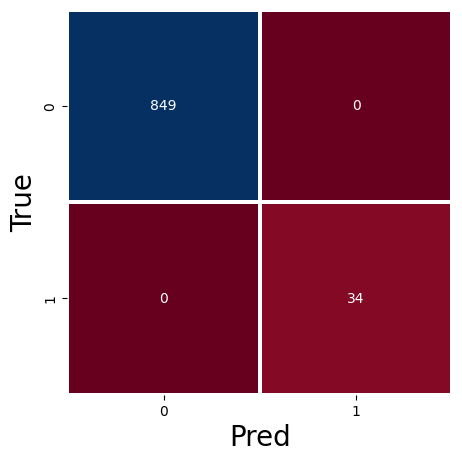

acc = 1.0
precision = 1.0
TPR = 1.0
FAR = 0.0
FRR = 0.0
average acc = 0.9949775961396424
average precision = 0.9469026963730864
average TPR = 0.9372836877570683
average FAR = 0.0024194418618645576
average FRR = 0.06271631224293174
average EER = 0.0


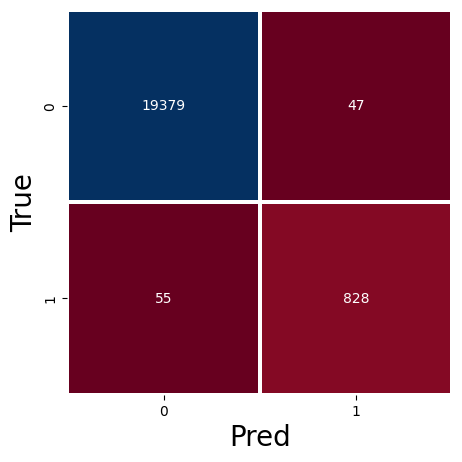

In [6]:
#Truly train the RF models that are going to be used

from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

precisionList = []
accList = []
tprList = []
farList = []
frrList = []
tnTotal, fpTotal, fnTotal, tpTotal = 0, 0, 0, 0

i=0
for df in dfList: 
    X = df.drop(columns=['label'])
    X = X.drop(columns=['pressureMedian'])
    X = X.drop(columns=['sizeMedian'])
    y = df['label']
    predicted_targets = np.array([])
    actual_targets = np.array([])
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42, stratify=y) #stratify=y means to keep the same ratio of labels in test set as the training set
    X_re, y_re = SMOTE(random_state=42, k_neighbors=2).fit_resample(X_train, y_train.astype('int')) #only apply SMOTE on training dataset
    #X_re, y_re = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train.astype('int'))
    
    RF_model = RandomForestClassifier(n_estimators=22)
    RF_model.fit(X_re,y_re)
    
    y_pred = RF_model.predict(X_test)
    predicted_targets = np.append(predicted_targets, y_pred)
    actual_targets = np.append(actual_targets, y_test)
    
    cm = confusion_matrix(actual_targets.astype('int'), predicted_targets)
    
    plt.figure(figsize=(12,5))
    sns.heatmap(cm,square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
    plt.xlabel('Pred',fontsize=20)
    plt.ylabel('True',fontsize=20)
    plt.show()
    
    
    tn, fp, fn, tp = cm.ravel()
    tnTotal += tn
    fpTotal += fp
    fnTotal += fn
    tpTotal += tp
    
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    tpr = tp/(tp+fn)
    far = fp/(fp+tn)
    frr = fn/(fn+tp)
    
    accList.append(accuracy)
    precisionList.append(precision)
    tprList.append(tpr)
    farList.append(far)
    frrList.append(frr)
    
    print("acc = "+str(accuracy))
    print("precision = "+str(precision))
    print("TPR = "+str(tpr))
    print("FAR = "+str(far))
    print("FRR = "+str(frr))

    initial_types = [
        ('input_data_type', FloatTensorType([None, 54]))
    ]

    converted_model = convert_sklearn(RF_model, initial_types=initial_types)
    with open(f"./models/model{i}.onnx", "wb") as f:
        f.write(converted_model.SerializeToString())
    i+=1
    
    
eval(accList, precisionList, tprList, farList, frrList, actual_targets.astype('int'), predicted_targets)

plt.figure(figsize=(12,5))
sns.heatmap(np.array([[tnTotal, fpTotal], [fnTotal, tpTotal]]),square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
plt.xlabel('Pred',fontsize=20)
plt.ylabel('True',fontsize=20)
plt.show()


In [24]:
df = train.onlyOneUser("temp.json", "611034")

#scaler = MinMaxScaler(feature_range=(0,1)).fit(df)
#df = scaler.transform(df)

108


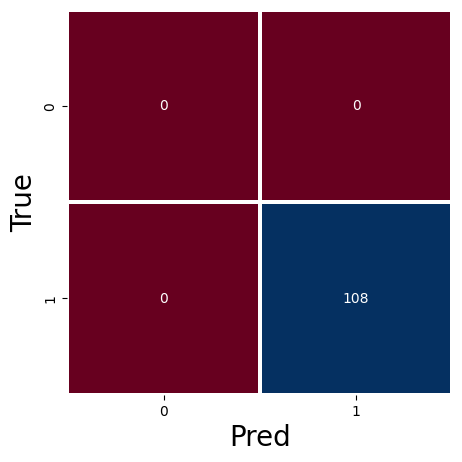

acc = 1.0
precision = 1.0
TPR = 1.0
FAR = nan
FRR = 0.0


C:\Users\louis\AppData\Local\Temp\ipykernel_8928\3917895081.py:46: RuntimeWarning: invalid value encountered in longlong_scalars
  far = fp/(fp+tn)


In [25]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnxruntime as rt

precisionList = []
accList = []
tprList = []
farList = []
frrList = []
tnTotal, fpTotal, fnTotal, tpTotal = 0, 0, 0, 0

y = df['label']
X = df.drop(columns=['label'])
X = X.drop(columns=['pressureMedian'])
X = X.drop(columns=['sizeMedian'])

predicted_targets = np.array([])
actual_targets = np.array([])

sess = rt.InferenceSession(
        f"./models/model4.onnx", providers=rt.get_available_providers())
input_name = sess.get_inputs()[0].name
    #print(X_test.astype(np.float32).to_dict('split')['data'])
    #break
y_pred = sess.run(None, {input_name: X.astype(np.float32).to_dict('split')['data']})[0]

predicted_targets = np.append(predicted_targets, y_pred)
actual_targets = np.append(actual_targets, y)

cm = confusion_matrix(actual_targets.astype('int'), predicted_targets.astype('int'), labels=[False, True])
plt.figure(figsize=(12,5))
sns.heatmap(cm,square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
plt.xlabel('Pred',fontsize=20)
plt.ylabel('True',fontsize=20)
plt.show()

tn, fp, fn, tp = cm.ravel()
tnTotal += tn
fpTotal += fp
fnTotal += fn
tpTotal += tp

accuracy = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
tpr = tp/(tp+fn)
far = fp/(fp+tn)
frr = fn/(fn+tp)

accList.append(accuracy)
precisionList.append(precision)
tprList.append(tpr)
farList.append(far)
frrList.append(frr)

print("acc = "+str(accuracy))
print("precision = "+str(precision))
print("TPR = "+str(tpr))
print("FAR = "+str(far))
print("FRR = "+str(frr))
    
#eval(accList, precisionList, tprList, farList, frrList, actual_targets.astype('int'), predicted_targets)
#plt.figure(figsize=(12,5))
#sns.heatmap(np.array([[tnTotal, fpTotal], [fnTotal, tpTotal]]),square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
#plt.xlabel('Pred',fontsize=20)
#plt.ylabel('True',fontsize=20)
#plt.show()


In [3]:
dfList = train.addNewData()

df1List = dfList
dfList = df1List
for df in dfList:
    scaler = MinMaxScaler(feature_range=(0,1)).fit(df)
    df = scaler.transform(df)

110
119
133
107
114
81
118
92
106
117
106
117
108
159


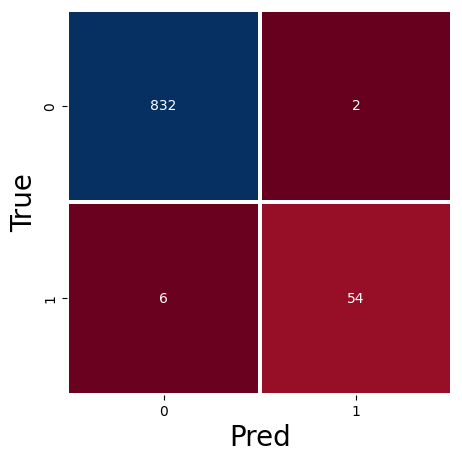

acc = 0.9910514541387024
precision = 0.9642857142857143
TPR = 0.9
FAR = 0.002398081534772182
FRR = 0.1


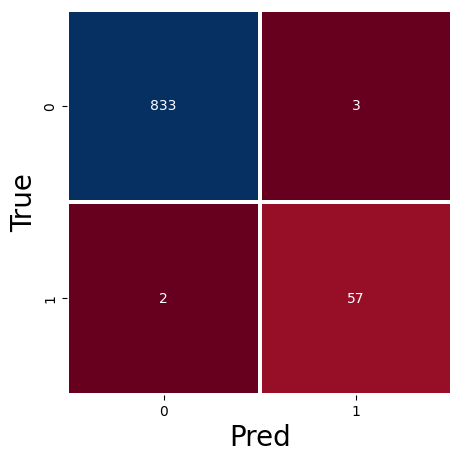

acc = 0.994413407821229
precision = 0.95
TPR = 0.9661016949152542
FAR = 0.0035885167464114833
FRR = 0.03389830508474576


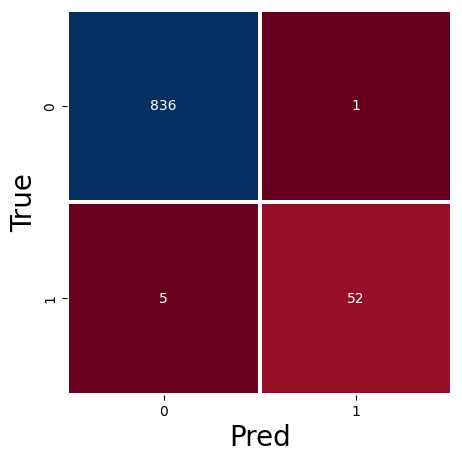

acc = 0.9932885906040269
precision = 0.9811320754716981
TPR = 0.9122807017543859
FAR = 0.0011947431302270011
FRR = 0.08771929824561403


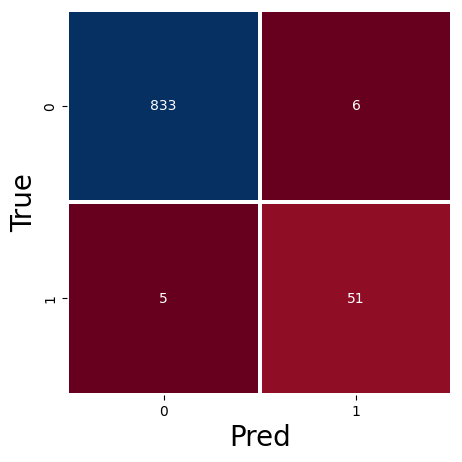

acc = 0.9877094972067039
precision = 0.8947368421052632
TPR = 0.9107142857142857
FAR = 0.007151370679380214
FRR = 0.08928571428571429


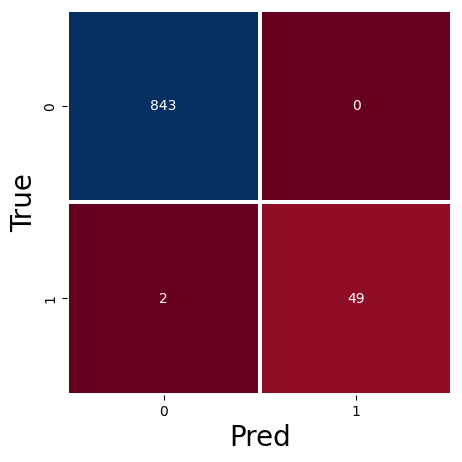

acc = 0.9977628635346756
precision = 1.0
TPR = 0.9607843137254902
FAR = 0.0
FRR = 0.0392156862745098


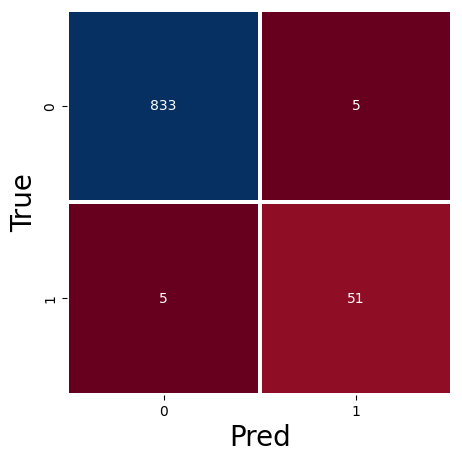

acc = 0.9888143176733781
precision = 0.9107142857142857
TPR = 0.9107142857142857
FAR = 0.0059665871121718375
FRR = 0.08928571428571429


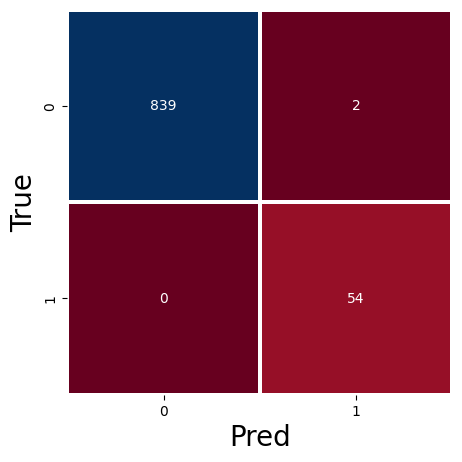

acc = 0.9977653631284916
precision = 0.9642857142857143
TPR = 1.0
FAR = 0.0023781212841854932
FRR = 0.0


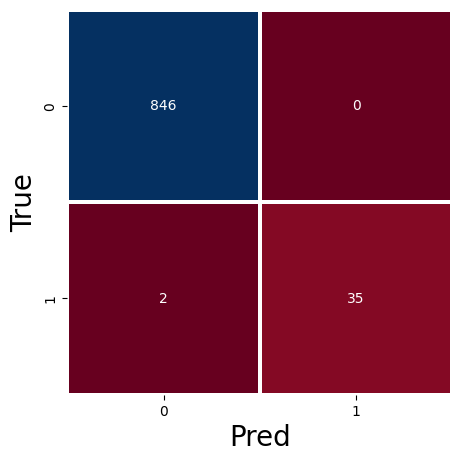

acc = 0.9977349943374858
precision = 1.0
TPR = 0.9459459459459459
FAR = 0.0
FRR = 0.05405405405405406


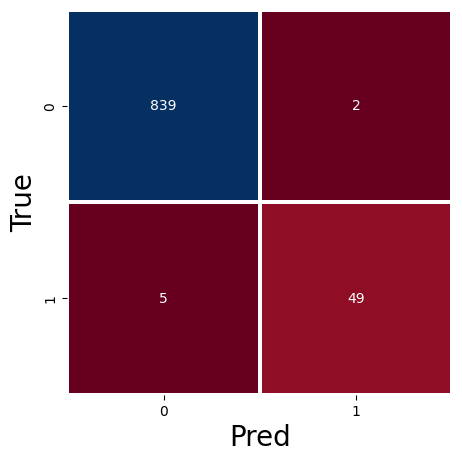

acc = 0.9921787709497206
precision = 0.9607843137254902
TPR = 0.9074074074074074
FAR = 0.0023781212841854932
FRR = 0.09259259259259259


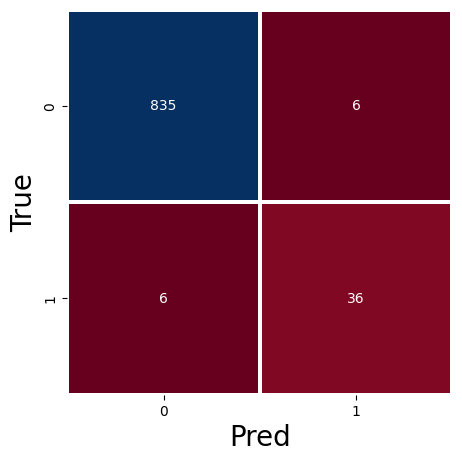

acc = 0.986409966024915
precision = 0.8571428571428571
TPR = 0.8571428571428571
FAR = 0.007134363852556481
FRR = 0.14285714285714285


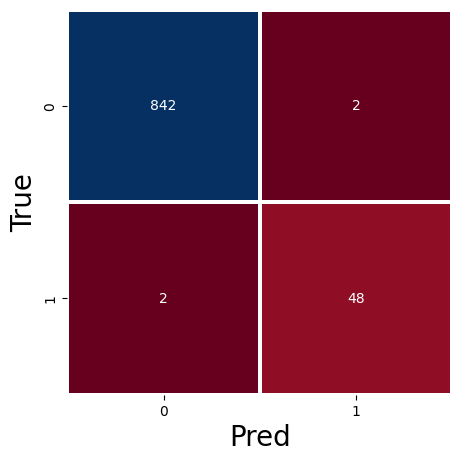

acc = 0.9955257270693513
precision = 0.96
TPR = 0.96
FAR = 0.002369668246445498
FRR = 0.04


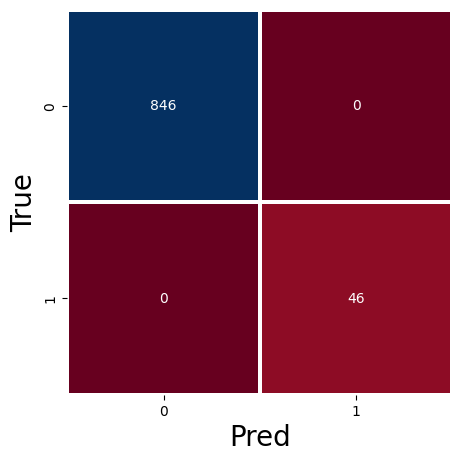

acc = 1.0
precision = 1.0
TPR = 1.0
FAR = 0.0
FRR = 0.0


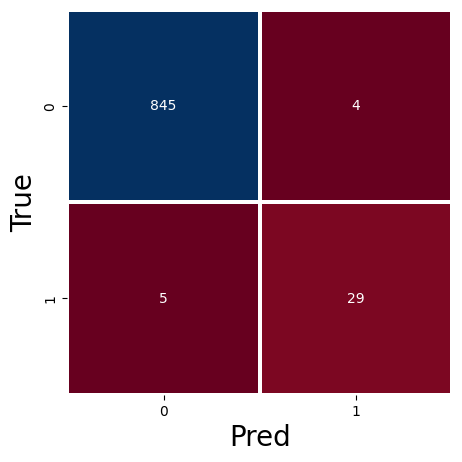

acc = 0.9898074745186863
precision = 0.8787878787878788
TPR = 0.8529411764705882
FAR = 0.004711425206124852
FRR = 0.14705882352941177


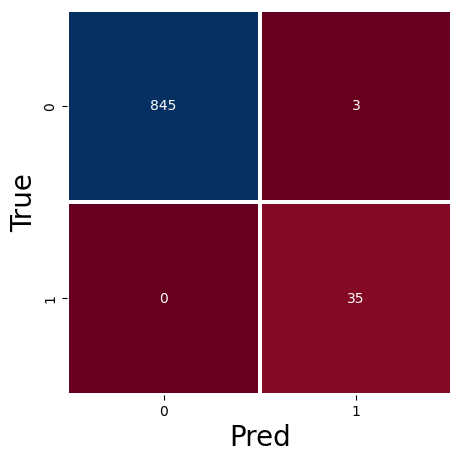

acc = 0.9966024915062288
precision = 0.9210526315789473
TPR = 1.0
FAR = 0.003537735849056604
FRR = 0.0


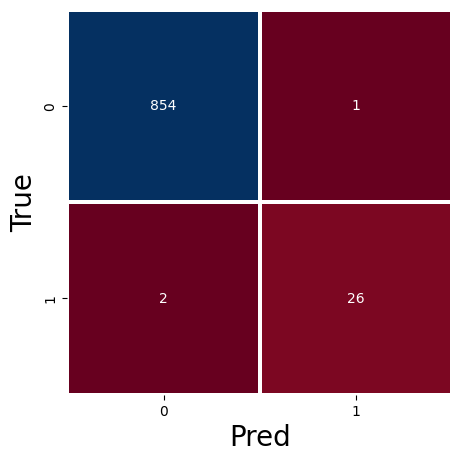

acc = 0.9966024915062288
precision = 0.9629629629629629
TPR = 0.9285714285714286
FAR = 0.0011695906432748538
FRR = 0.07142857142857142


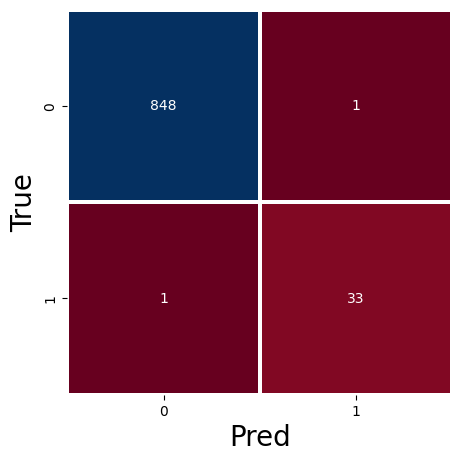

acc = 0.9977349943374858
precision = 0.9705882352941176
TPR = 0.9705882352941176
FAR = 0.001177856301531213
FRR = 0.029411764705882353


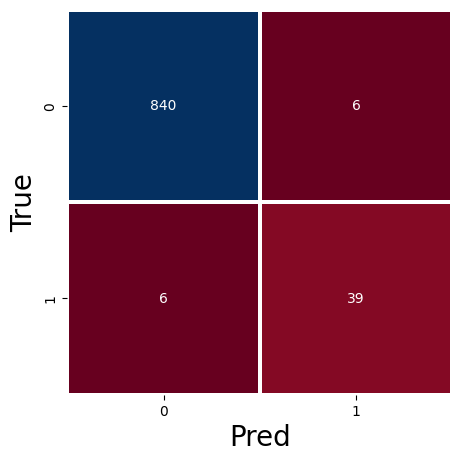

acc = 0.9865319865319865
precision = 0.8666666666666667
TPR = 0.8666666666666667
FAR = 0.0070921985815602835
FRR = 0.13333333333333333


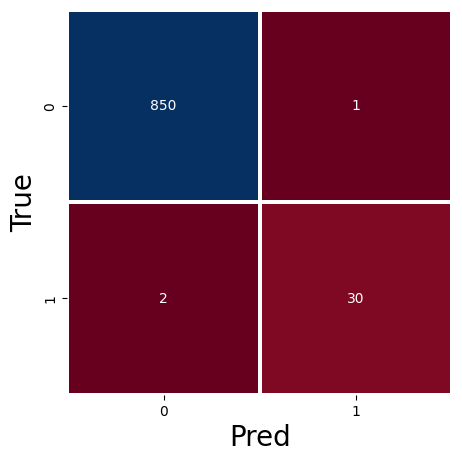

acc = 0.9966024915062288
precision = 0.967741935483871
TPR = 0.9375
FAR = 0.0011750881316098707
FRR = 0.0625


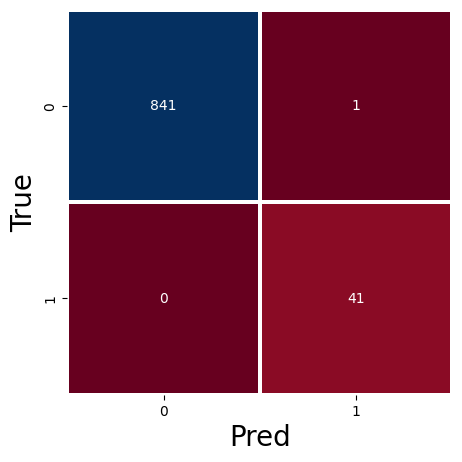

acc = 0.9988674971687429
precision = 0.9761904761904762
TPR = 1.0
FAR = 0.0011876484560570072
FRR = 0.0


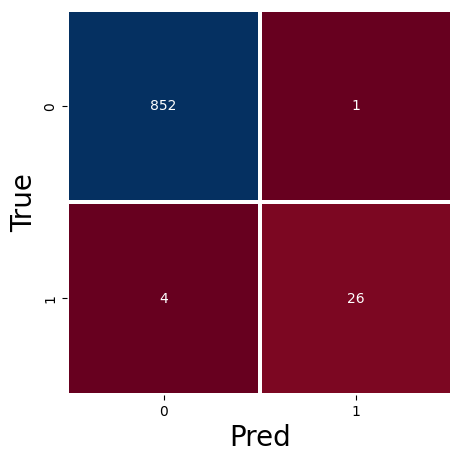

acc = 0.9943374858437146
precision = 0.9629629629629629
TPR = 0.8666666666666667
FAR = 0.0011723329425556857
FRR = 0.13333333333333333


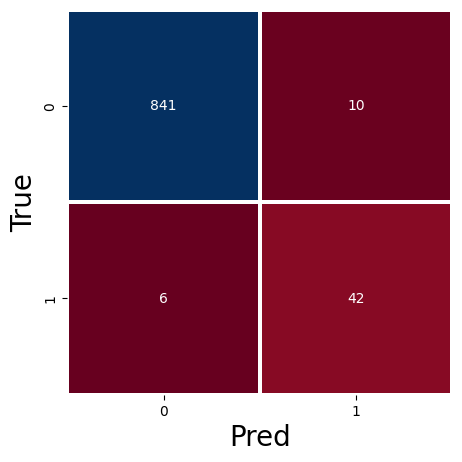

acc = 0.982202447163515
precision = 0.8076923076923077
TPR = 0.875
FAR = 0.011750881316098707
FRR = 0.125


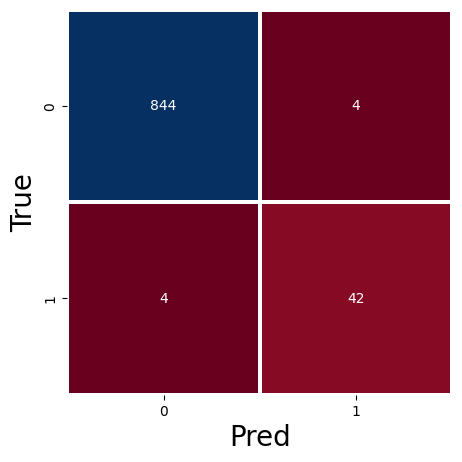

acc = 0.9910514541387024
precision = 0.9130434782608695
TPR = 0.9130434782608695
FAR = 0.0047169811320754715
FRR = 0.08695652173913043


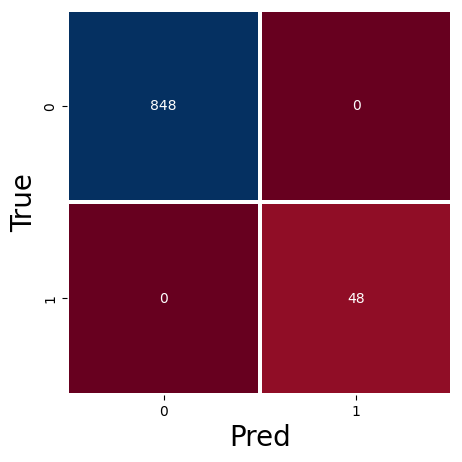

acc = 1.0
precision = 1.0
TPR = 1.0
FAR = 0.0
FRR = 0.0
average acc = 0.9936085115960956
average precision = 0.9422074495048731
average TPR = 0.9322638758369675
average FAR = 0.0031413614100121844
average FRR = 0.06773612416303262
average EER = 0.0


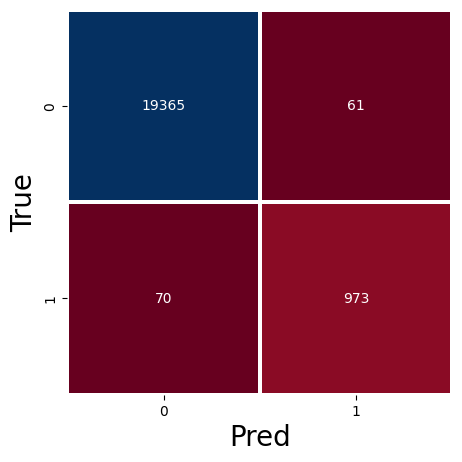

In [4]:
#Truly train the RF models that are going to be used

from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

precisionList = []
accList = []
tprList = []
farList = []
frrList = []
tnTotal, fpTotal, fnTotal, tpTotal = 0, 0, 0, 0

i=0
for df in dfList: 
    X = df.drop(columns=['label'])
    X = X.drop(columns=['pressureMedian'])
    X = X.drop(columns=['sizeMedian'])
    y = df['label']
    predicted_targets = np.array([])
    actual_targets = np.array([])
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42, stratify=y) #stratify=y means to keep the same ratio of labels in test set as the training set
    X_re, y_re = SMOTE(random_state=42, k_neighbors=2).fit_resample(X_train, y_train.astype('int')) #only apply SMOTE on training dataset
    #X_re, y_re = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train.astype('int'))
    #print(X_train.shape)
    #print(X_re.shape)
    #k_fold = KFold(5, shuffle=True, random_state=42)
    '''
    for train_ix, test_ix in k_fold.split(X):
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]    

        
    
        RF = RandomForestClassifier(n_estimators=22)

        RF.fit(X_re,y_re)
    #model.fit(X_train, y_train.astype('int'))
        y_pred = RF.predict(X_test)
        predicted_targets = np.append(predicted_targets, y_pred)
        actual_targets = np.append(actual_targets, y_test)
    '''
    RF_model = RandomForestClassifier(n_estimators=22)
    RF_model.fit(X_re,y_re)
    
    #import pickle
    #pickle.dump(RF_model, open(f"./models/rf{i}.pickle", "wb"))
    
    y_pred = RF_model.predict(X_test)
    predicted_targets = np.append(predicted_targets, y_pred)
    actual_targets = np.append(actual_targets, y_test)
    
    cm = confusion_matrix(actual_targets.astype('int'), predicted_targets)
    
    plt.figure(figsize=(12,5))
    sns.heatmap(cm,square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
    plt.xlabel('Pred',fontsize=20)
    plt.ylabel('True',fontsize=20)
    plt.show()
    
    
    tn, fp, fn, tp = cm.ravel()
    tnTotal += tn
    fpTotal += fp
    fnTotal += fn
    tpTotal += tp
    
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    tpr = tp/(tp+fn)
    far = fp/(fp+tn)
    frr = fn/(fn+tp)
    
    accList.append(accuracy)
    precisionList.append(precision)
    tprList.append(tpr)
    farList.append(far)
    frrList.append(frr)
    
    print("acc = "+str(accuracy))
    print("precision = "+str(precision))
    print("TPR = "+str(tpr))
    print("FAR = "+str(far))
    print("FRR = "+str(frr))

    initial_types = [
        ('input_data_type', FloatTensorType([None, 54]))
    ]

    converted_model = convert_sklearn(RF_model, initial_types=initial_types)
    with open(f"./models/model{i}.onnx", "wb") as f:
        f.write(converted_model.SerializeToString())
    i+=1
    
eval(accList, precisionList, tprList, farList, frrList, actual_targets.astype('int'), predicted_targets)

plt.figure(figsize=(12,5))
sns.heatmap(np.array([[tnTotal, fpTotal], [fnTotal, tpTotal]]),square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
plt.xlabel('Pred',fontsize=20)
plt.ylabel('True',fontsize=20)
plt.show()

In [5]:
dfList = train.transform("temp.json")

for df in dfList:
    scaler = MinMaxScaler(feature_range=(0,1)).fit(df)
    df = scaler.transform(df)

NOW SHOWING: 1092954


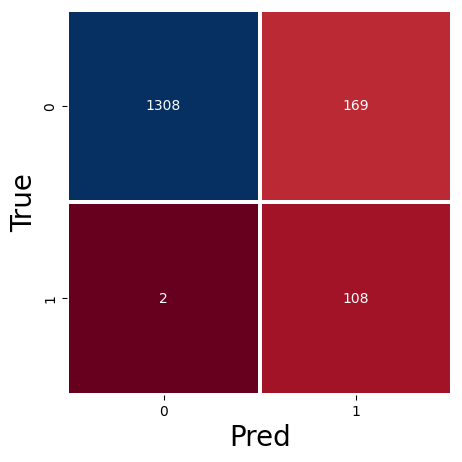

acc = 0.8922495274102079
precision = 0.3898916967509025
TPR = 0.9818181818181818
FAR = 0.11442112389979689
FRR = 0.01818181818181818
NOW SHOWING: dama0623


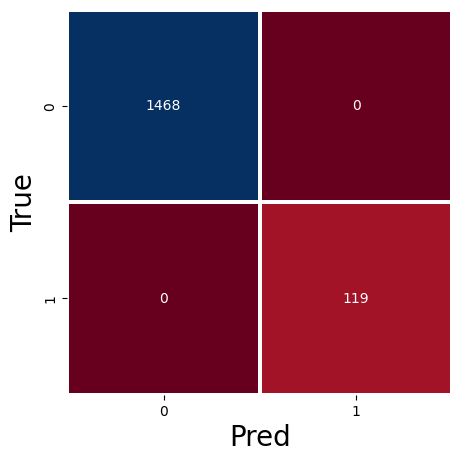

acc = 1.0
precision = 1.0
TPR = 1.0
FAR = 0.0
FRR = 0.0
NOW SHOWING: 1094908


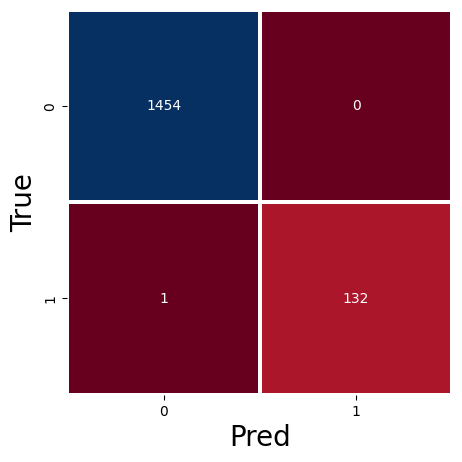

acc = 0.9993698802772527
precision = 1.0
TPR = 0.9924812030075187
FAR = 0.0
FRR = 0.007518796992481203
NOW SHOWING: 4109034029


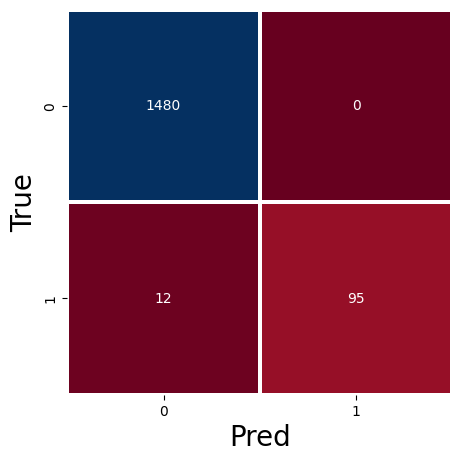

acc = 0.9924385633270322
precision = 1.0
TPR = 0.8878504672897196
FAR = 0.0
FRR = 0.11214953271028037
NOW SHOWING: 611034


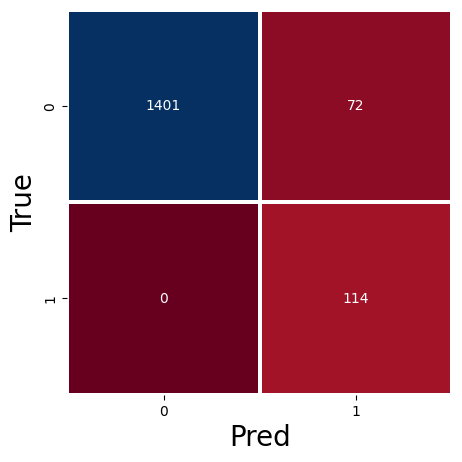

acc = 0.9546313799621928
precision = 0.6129032258064516
TPR = 1.0
FAR = 0.048879837067209775
FRR = 0.0
NOW SHOWING: 1094841


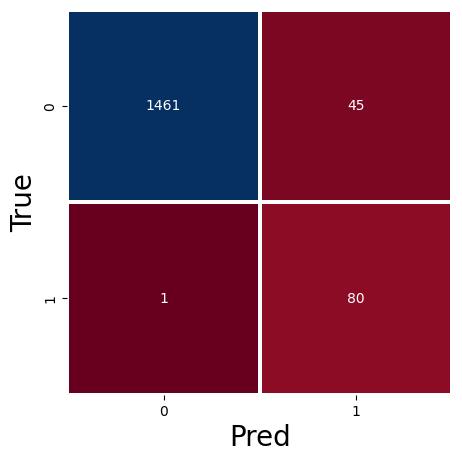

acc = 0.9710144927536232
precision = 0.64
TPR = 0.9876543209876543
FAR = 0.029880478087649404
FRR = 0.012345679012345678
NOW SHOWING: D1186959


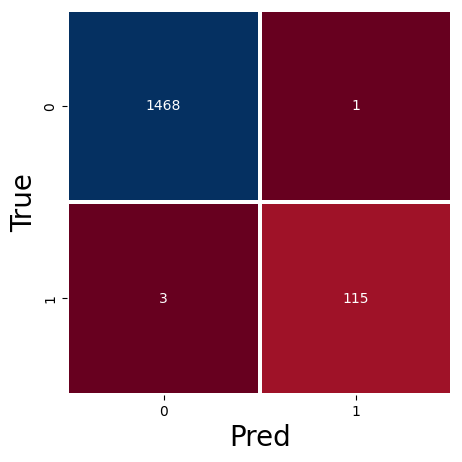

acc = 0.9974795211090107
precision = 0.9913793103448276
TPR = 0.9745762711864406
FAR = 0.0006807351940095302
FRR = 0.025423728813559324
NOW SHOWING: 411411159


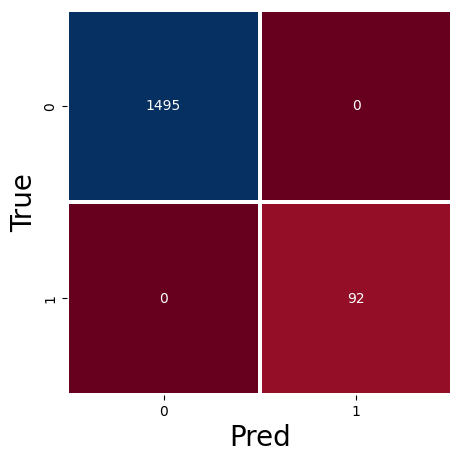

acc = 1.0
precision = 1.0
TPR = 1.0
FAR = 0.0
FRR = 0.0
NOW SHOWING: 1094845


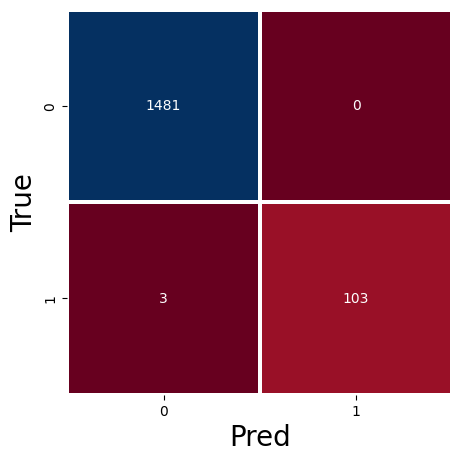

acc = 0.998109640831758
precision = 1.0
TPR = 0.9716981132075472
FAR = 0.0
FRR = 0.02830188679245283
NOW SHOWING: 1094842


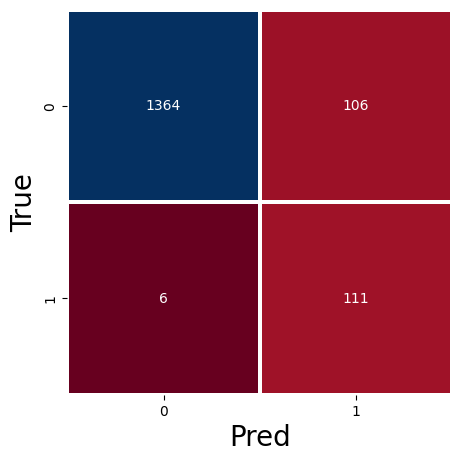

acc = 0.9294265910523
precision = 0.511520737327189
TPR = 0.9487179487179487
FAR = 0.07210884353741497
FRR = 0.05128205128205128
NOW SHOWING: 110


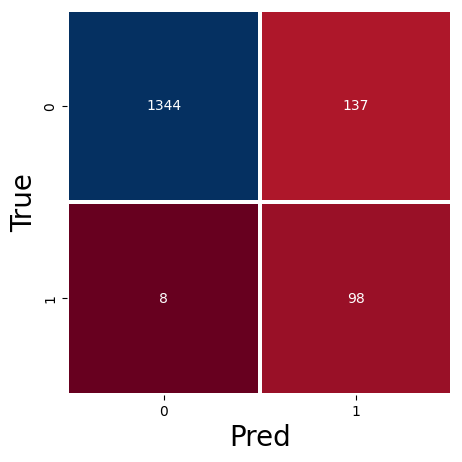

acc = 0.9086326402016384
precision = 0.41702127659574467
TPR = 0.9245283018867925
FAR = 0.0925050641458474
FRR = 0.07547169811320754
NOW SHOWING: pomiii5093


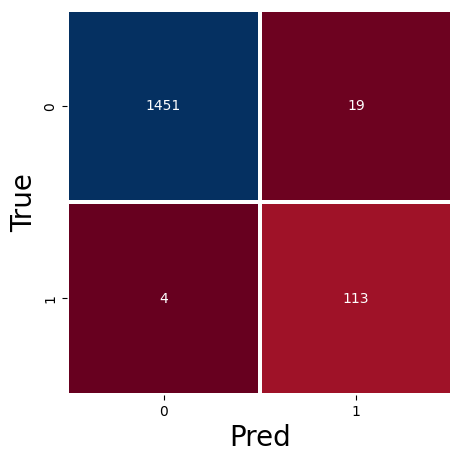

acc = 0.9855072463768116
precision = 0.8560606060606061
TPR = 0.9658119658119658
FAR = 0.01292517006802721
FRR = 0.03418803418803419
NOW SHOWING: 1092574


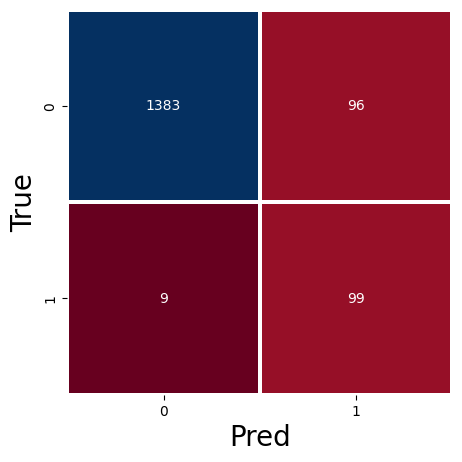

acc = 0.9338374291115312
precision = 0.5076923076923077
TPR = 0.9166666666666666
FAR = 0.06490872210953347
FRR = 0.08333333333333333
NOW SHOWING: anyu5471


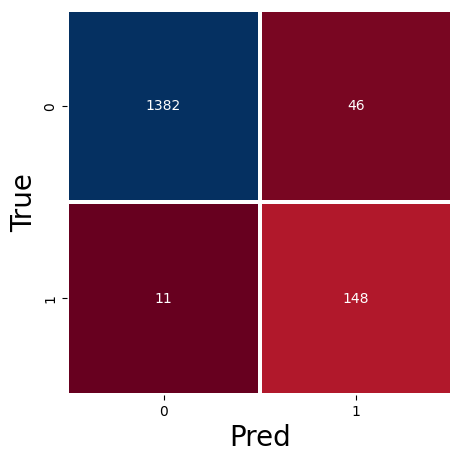

acc = 0.9640831758034026
precision = 0.7628865979381443
TPR = 0.9308176100628931
FAR = 0.03221288515406162
FRR = 0.06918238993710692
average acc = 0.9661985777297686
average precision = 0.7635254113225839
average TPR = 0.9630443607602377
average FAR = 0.03346591851882502
average FRR = 0.0369556392397622
average EER = 0.03221288515406162


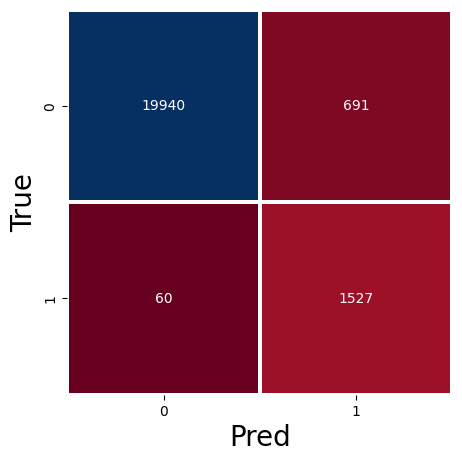

In [6]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnxruntime as rt
import json

userOrder = []
userList = ["1092954", "dama0623", "1094908", "4109034029", "611034", "1094841", "D1186959",
                "411411159", "1094845", "1094842", "110", "pomiii5093", "1092574", "anyu5471", "px",
                "wardlin", "lenny", "1092960", "1092923", "1092950", "1092942", "1092928", "1092922"]

with open("evaluationData.json", 'r') as f:
    data = json.load(f)
    numSubject = len(data)
    for i in data.keys():
        userOrder.append(userList.index(i))

i=0

precisionList = []
accList = []
tprList = []
farList = []
frrList = []
tnTotal, fpTotal, fnTotal, tpTotal = 0, 0, 0, 0

for df in dfList:
    y = df['label']
    X = df.drop(columns=['label'])
    X = X.drop(columns=['pressureMedian'])
    X = X.drop(columns=['sizeMedian'])

    predicted_targets = np.array([])
    actual_targets = np.array([])

    sess = rt.InferenceSession(
            f"./models/model{userOrder[i]}.onnx", providers=rt.get_available_providers())
    
    input_name = sess.get_inputs()[0].name
        #print(X_test.astype(np.float32).to_dict('split')['data'])
        #break
    y_pred = sess.run(None, {input_name: X.astype(np.float32).to_dict('split')['data']})[0]

    predicted_targets = np.append(predicted_targets, y_pred)
    actual_targets = np.append(actual_targets, y)

    print("NOW SHOWING: " + str(userList[i]))
    cm = confusion_matrix(actual_targets.astype('int'), predicted_targets.astype('int'), labels=[False, True])
    plt.figure(figsize=(12,5))
    sns.heatmap(cm,square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
    plt.xlabel('Pred',fontsize=20)
    plt.ylabel('True',fontsize=20)
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    tnTotal += tn
    fpTotal += fp
    fnTotal += fn
    tpTotal += tp

    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    tpr = tp/(tp+fn)
    far = fp/(fp+tn)
    frr = fn/(fn+tp)

    accList.append(accuracy)
    precisionList.append(precision)
    tprList.append(tpr)
    farList.append(far)
    frrList.append(frr)

    print("acc = "+str(accuracy))
    print("precision = "+str(precision))
    print("TPR = "+str(tpr))
    print("FAR = "+str(far))
    print("FRR = "+str(frr))
    i+=1
    
eval(accList, precisionList, tprList, farList, frrList, actual_targets.astype('int'), predicted_targets)

plt.figure(figsize=(12,5))
sns.heatmap(np.array([[tnTotal, fpTotal], [fnTotal, tpTotal]]),square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
plt.xlabel('Pred',fontsize=20)
plt.ylabel('True',fontsize=20)
plt.show()
